# Setup

In [4]:
include(joinpath("..","src","setup.jl"))

datadir = joinpath("..","data","count_lengths","run_2018-11-16")

┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/AuditoryBistabilityLE/RqG8S.ji for AuditoryBistabilityLE [7e25a372-ade5-11e8-17af-a30e5a9e2c28]
└ @ Base loading.jl:1190


┌ Info: Recompiling stale cache file /Users/davidlittle/.julia/compiled/v1.0/Gadfly/DvECm.ji for Gadfly [c91e804a-d5a3-530f-b6f0-dfbca275c004]
└ @ Base loading.jl:1190
┌ Warning: Module JSON with build ID 144403792739145 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Warning: Module JSON with build ID 144403792739145 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Precompiling Compose [a81c6b42-2e10-5240-aca2-a61377ecd94b]
└ @ Base loading.jl:1192
┌ Warning: Module JSON with build ID 144403792739145 is missing from the cache.
│ This may mean JSON [682c06a0-de6a-54ab-a142-c8b1cf79cde6] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:947
┌ Info: Recompiling stale cache fi

"../data/count_lengths/run_2018-11-16"

# TODO:
- start taking a look at the new data (from the 11-16 run)
- verify the range of parameters we've selected
- sketch of plot for early results / aim 1
- figure out sketch of plots for Aim 2
- plots for early results and aim 1
- plots for aim 2
- run the sensitivity analyses
- run the factorial analysis

# Questions

Why does bistability arise with no adaptation for the scale-level? (or the object level?)

# Load data

In [5]:
params = load(joinpath(datadir,"params.jld2"),"params")
params[:pindex] = 1:size(params,1)
settings = joinpath("..","src","settings.toml")

results = []
setfile = AuditoryBistabilityLE.read_settings(settings)
for_results_in(joinpath(datadir,"data")) do entry
  # with_logger(NullLogger()) do
  #     lengths, percepts = percept_lengths(audiospect(entry["mask"],setfile),params[entry["pindex"],:],setfile)
  #     push!(results,DataFrame(length=lengths,percepts=percepts.+1,created=entry["created"],pindex=entry["pindex"]))
  # end
  
  push!(results,DataFrame(length=entry["lengths"],
                          percepts=entry["percepts"].+1, # after +1, indicates the number of streams reported, 1 or 2
                          created=entry["created"],
                          pindex=entry["pindex"])) # the parameter index (pindex = N correspondes to row N of `params`)
end
df = vcat(results...);
head(df)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:03


,length,percepts,created,pindex
,Float64,Int64,DateTime,Int64
1,26.0,1,2018-11-16T15:51:23.689,1
2,0.9,2,2018-11-16T15:51:23.689,1
3,12.3,1,2018-11-16T15:51:23.689,1
4,1.1,2,2018-11-16T15:51:23.689,1
5,7.0,1,2018-11-16T15:51:23.689,1
6,0.7,2,2018-11-16T15:52:44.978,1


In [7]:
sim_length = jldopen(joinpath(datadir,"data",readdir(joinpath(datadir,"data"))[1]),"r") do first_file
    last(first_file["btimes_s"])
end

47.6

In [273]:
include(joinpath(srcdir,"setup.jl"));

In [ ]:
dfh = setup_human_data()
fields = [:f_c_a,:f_c_m,:f_c_σ,:s_c_a,:s_c_m,:s_c_σ,:t_c_a,:t_c_m,:t_c_σ]
progress = Progress(nrow(unique(params[fields])))
df_summary = by(@where(params,:Δf .== 6),fields) do row
    next!(progress)
    result =
        model_rms(df,params,dfh,return_parts=true,
                  f_c_a=row[1,:f_c_a], f_c_m=row[1,:f_c_m], f_c_σ = row[1,:f_c_σ],
                  s_c_a=row[1,:s_c_a], s_c_m=row[1,:s_c_m], s_c_σ = row[1,:s_c_σ],
                  t_c_a=row[1,:t_c_a], t_c_m=row[1,:t_c_m], t_c_σ = row[1,:t_c_σ])
    DataFrame([result])
end
head(df_summary)

Progress:   1%|█                                        |  ETA: 0:04:24

In [207]:
function rename_levels_for(df,vals)
    df[:c_m] = NaN
    df[:c_a] = NaN
    df[:level] = "unknown"
    @byrow! df begin
        if :f_c_σ > 0 
           :level = "Peripheral"
            :c_m = :f_c_m
            :c_a = :f_c_a
        elseif :s_c_σ > 0 
            :level = "Cortical"
            :c_m = :s_c_m
            :c_a = :s_c_a
        elseif :t_c_σ > 0 
            :level = "Object"
            :c_m = :t_c_m
            :c_a = :t_c_a
        end
    end
    df[[:c_m;:c_a;:level;vals]]
end
        
DataFramesMeta.linq(::DataFramesMeta.SymbolParameter{:rename_levels}, df, vals) = :(rename_levels($df,$vals))

In [208]:
dfplot = @linq df_summary |>
    rename_levels_for(:rms) |>
    transform(log_a = ifelse.(iszero.(:c_a),:c_a,log.(:c_a)),
              log_m = ifelse.(iszero.(:c_m),:c_m,log.(:c_m)),
              rms_str = string.(round.(:rms,digits=1)))

,c_m,c_a,level,rms,log_a,log_m,rms_str
,Float64,Float64,String,Float64,Float64,Float64,String
1,0.0,0.0,Peripheral,1.64827,0.0,0.0,1.6
2,5.0,0.0,Peripheral,1.64412,0.0,1.60944,1.6
3,15.0,0.0,Peripheral,1.6548,0.0,2.70805,1.7
4,44.0,0.0,Peripheral,1.62327,0.0,3.78419,1.6
5,130.0,0.0,Peripheral,1.65448,0.0,4.86753,1.7
6,385.0,0.0,Peripheral,1.66434,0.0,5.95324,1.7
7,1141.0,0.0,Peripheral,1.59517,0.0,7.03966,1.6
8,3377.0,0.0,Peripheral,1.67257,0.0,8.12474,1.7
9,10000.0,0.0,Peripheral,1.6735,0.0,9.21034,1.7


In [210]:
using Gadfly

In [242]:
scale = reverse!(colormap("RdBu",mid=(2.5-1)/2.5));


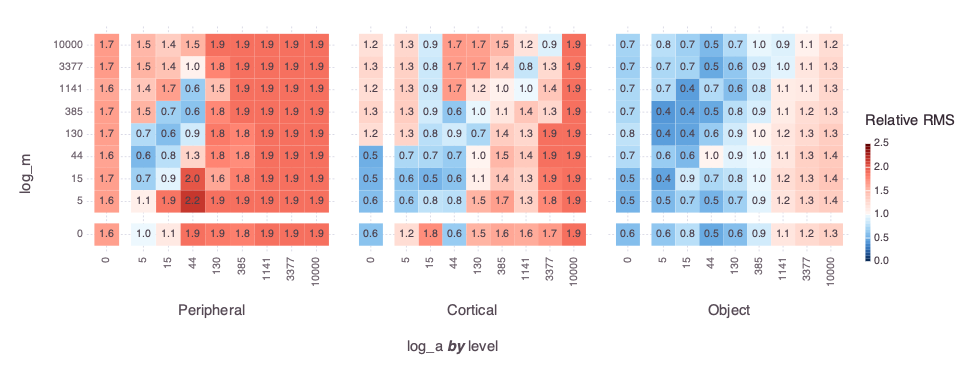

false

In [254]:
vals = [0.0; log.(dfplot[2:9,:c_m])]
draw(PNG(10inch,4inch),plot(dfplot,x=:log_a,y=:log_m,color=:rms,xgroup=:level,label=:rms_str,
     Geom.subplot_grid(Geom.label(position=:centered),Geom.rectbin,Coord.cartesian(ymin=0,xmin=0),
                       Guide.xticks(ticks=vals,orientation=:vertical),
                       Guide.yticks(ticks=vals,orientation=:horizontal)),
     Scale.color_continuous(maxvalue=2.5,colormap=x -> scale[1+floor(Int,99*x)]),
     Guide.colorkey(title="Relative RMS"),
     Scale.x_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x)))),
     Scale.y_continuous(labels=x -> iszero(x) ? "0" : string(round(Int,exp(x))))))

# Peripheral-level

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


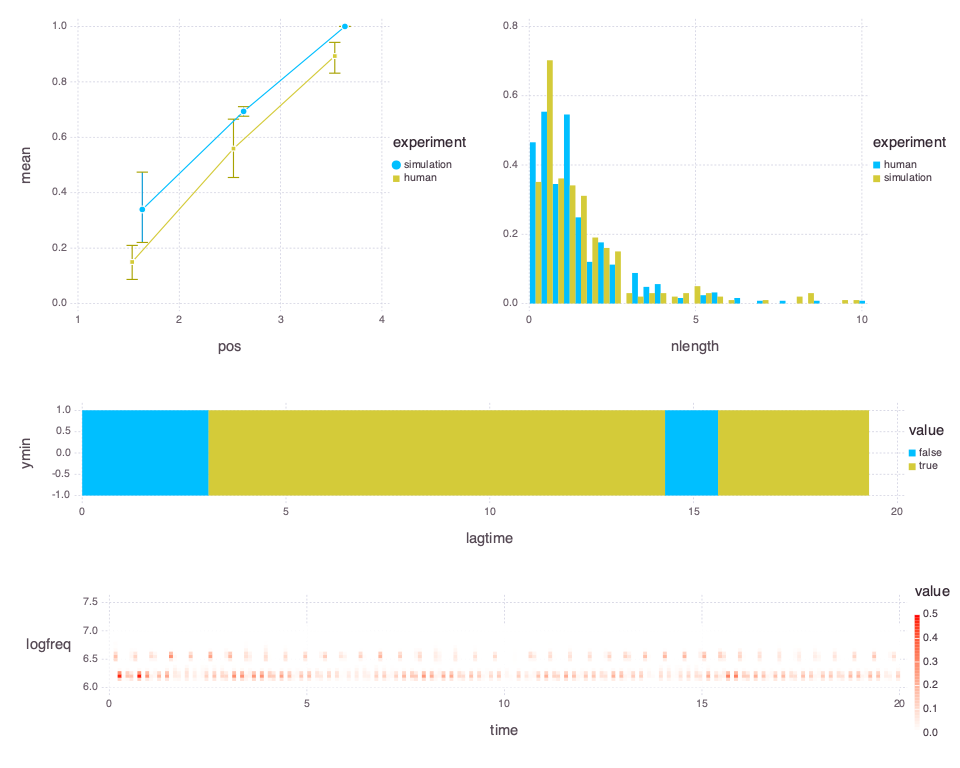

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [186]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=5,f_c_m=44))

possible claim: selectivity and bistability disappears, strong "bias" or basically a single percept shown
this will show up as
- bad streaming rms
- bad lengths rms
- poor match between mean and individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


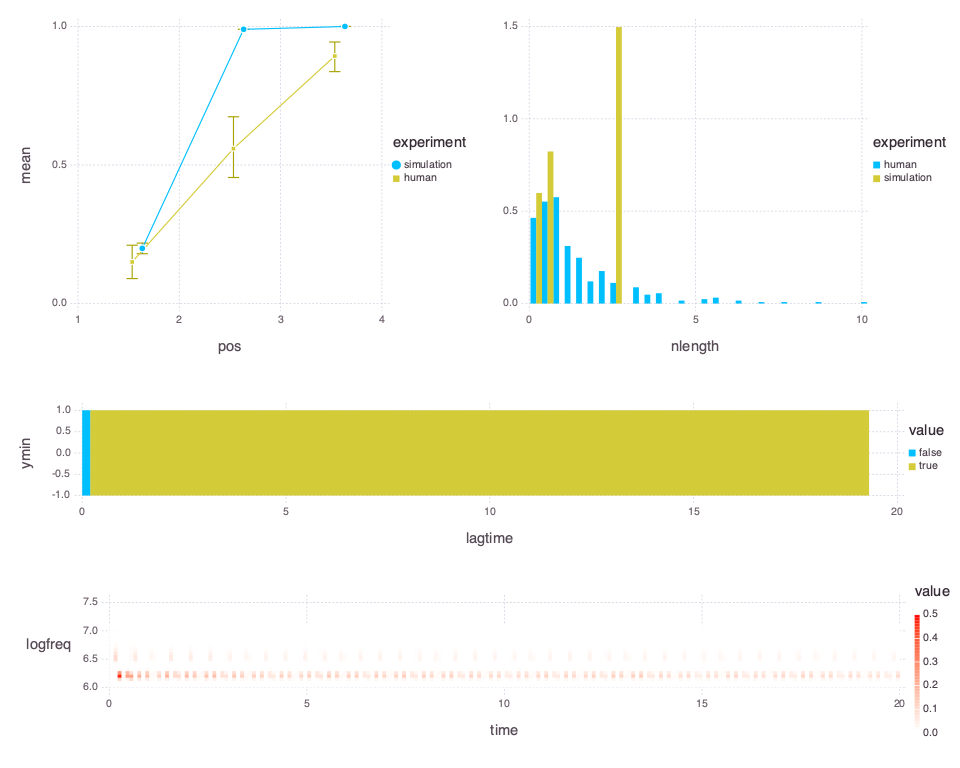

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [188]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=5,f_c_m=385))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


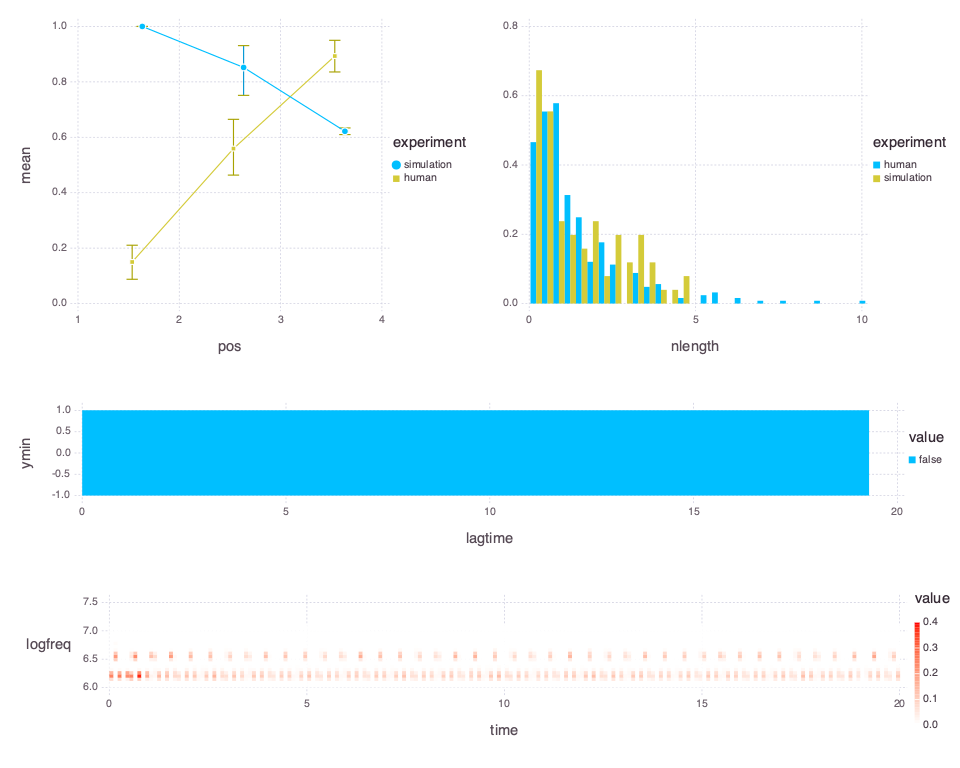

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [189]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,f_c_a=44,f_c_m=44))

# Cortical-level

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

In [267]:
stream_rms(df,params,stream_dfh(),s_c_a=15,s_c_m=15,mean_v_ind=true)

(0.7885460752143734, 0.5791611300198476)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


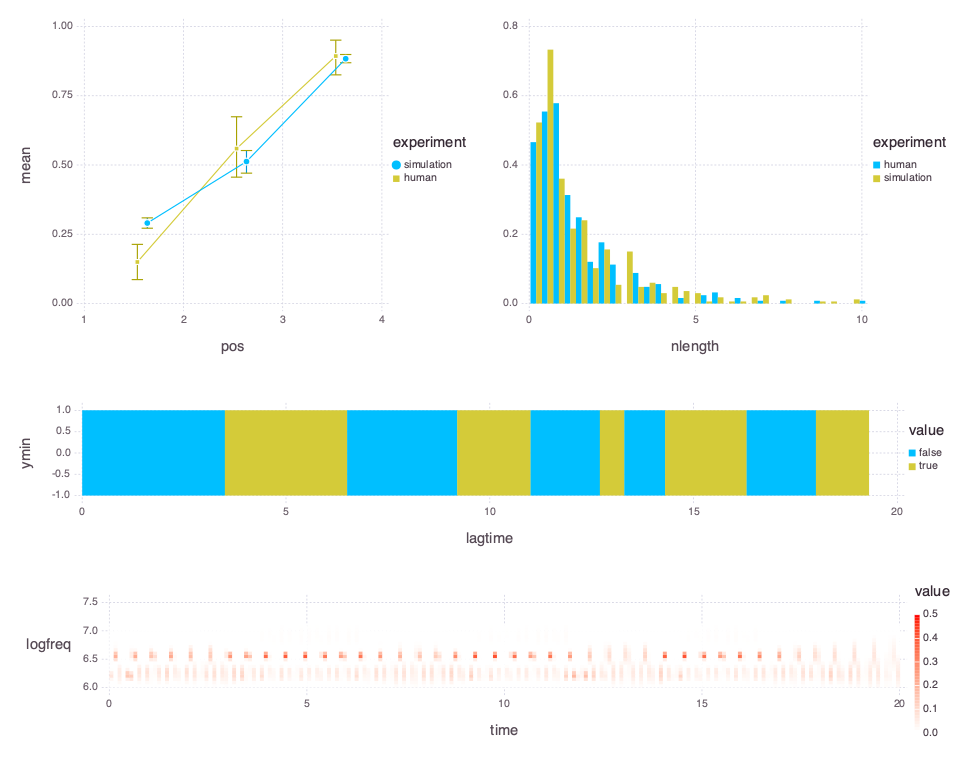

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [190]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=15,s_c_m=15))

In [266]:
stream_rms(df,params,stream_dfh(),s_c_a=130,s_c_m=15,mean_v_ind=true)

(1.8388431724488226, 1.6210451699346744)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


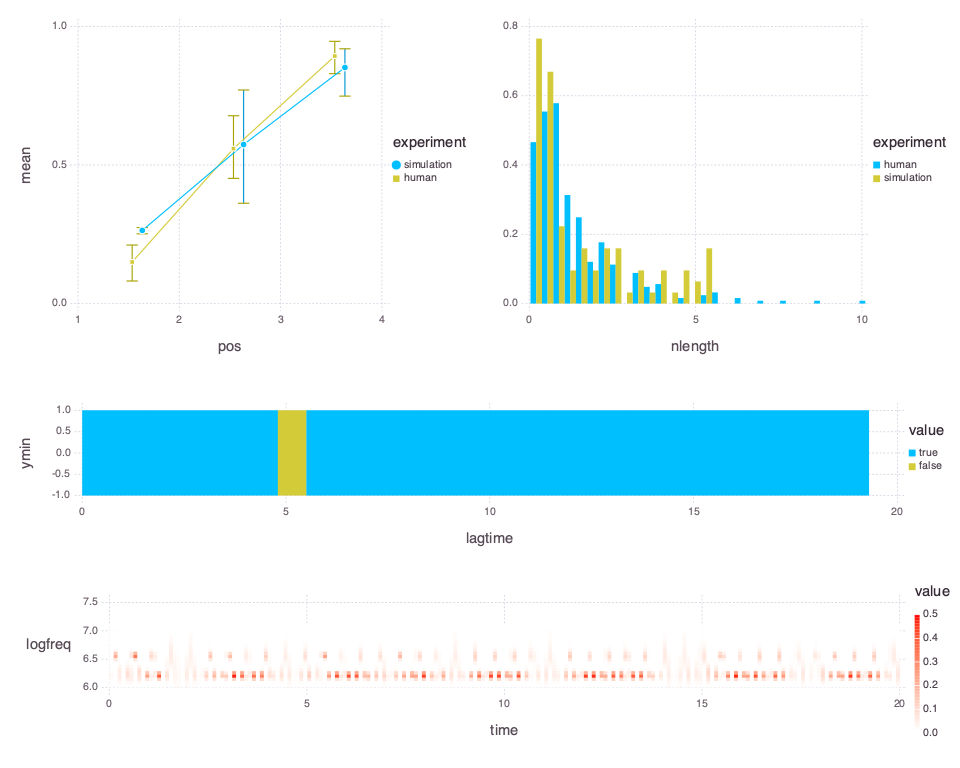

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [191]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=130,s_c_m=15))

In [268]:
stream_rms(df,params,stream_dfh(),s_c_a=5,s_c_m=130,mean_v_ind=true)

(2.2816547442345994, 3.471836687006393)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


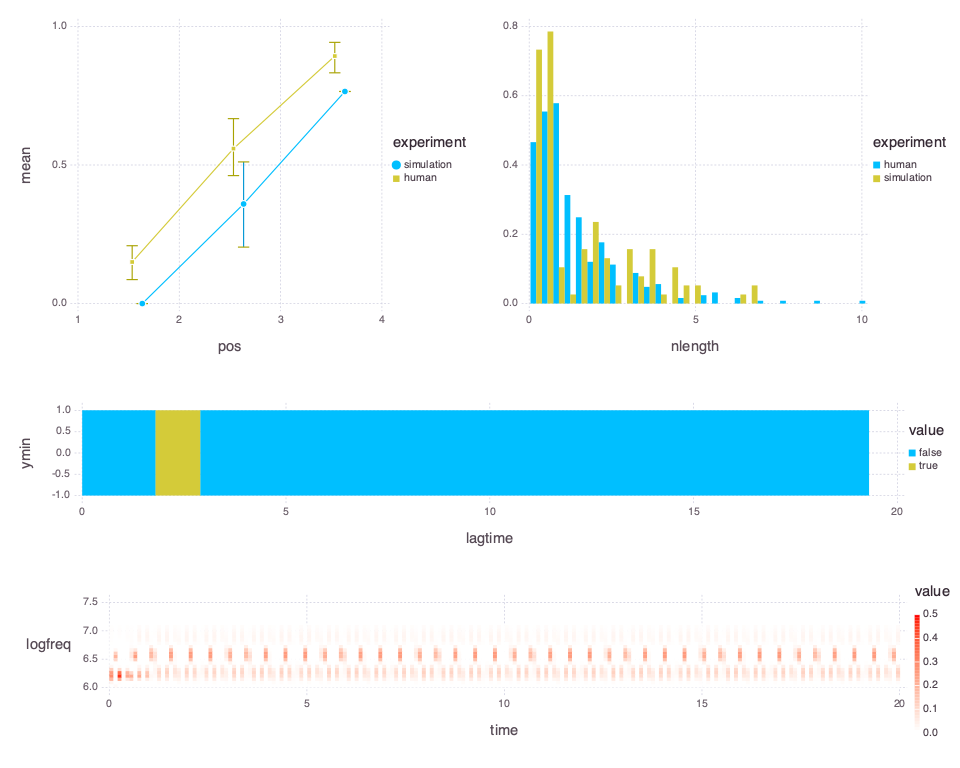

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [192]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,s_c_a=5,s_c_m=130))

# Object-level

In [ ]:
possible claim: bistability remains, selectivity reduced at offset values

- poor streaming rms
- good length rms
- good match of mean to individual rms

Possible claim: selectivity and bistability remains, string, ongoing bias for a given simulation. This will show up as:

- good streaming rms
- good length rms
- poor match of mean to individual rms

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


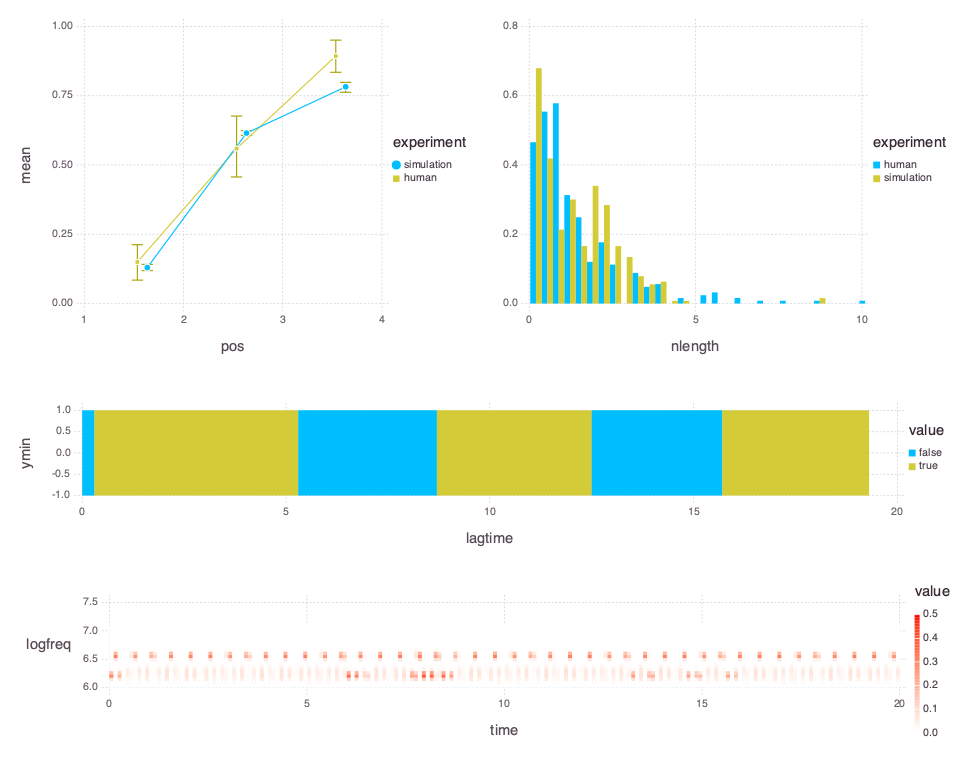

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [194]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=15,t_c_m=1141))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


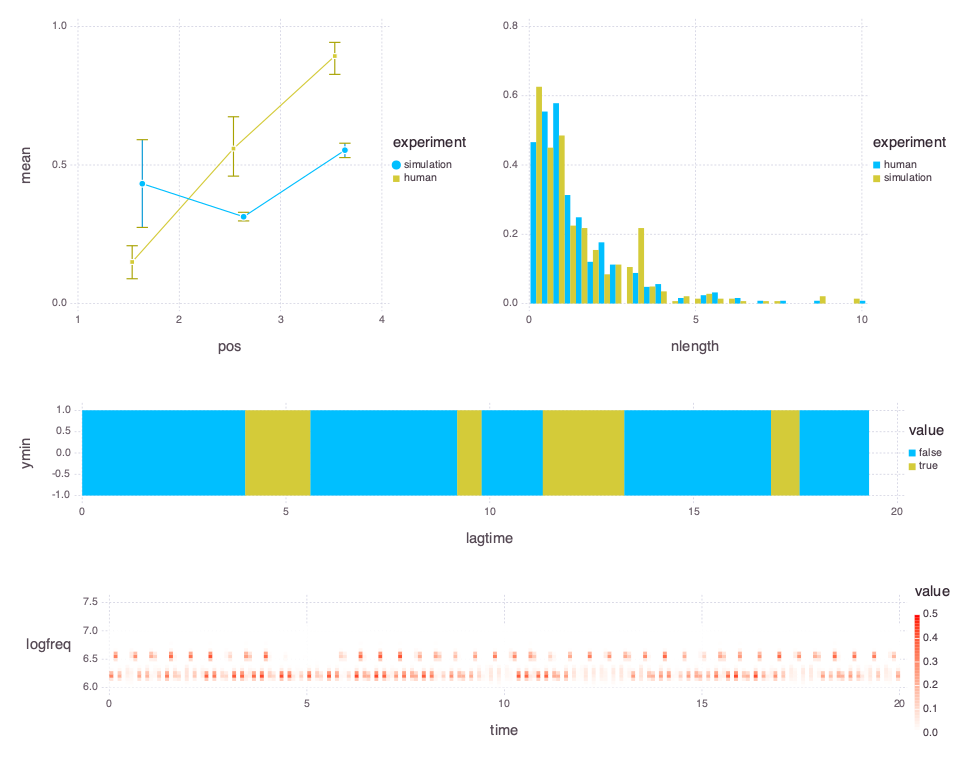

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [195]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=1141,t_c_m=1141))

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00
┌ Warning: Some of the frequency channels are missing.
└ @ ShammaModel /Users/davidlittle/googledrive/juliadev/ShammaModel/src/audiospect.jl:146


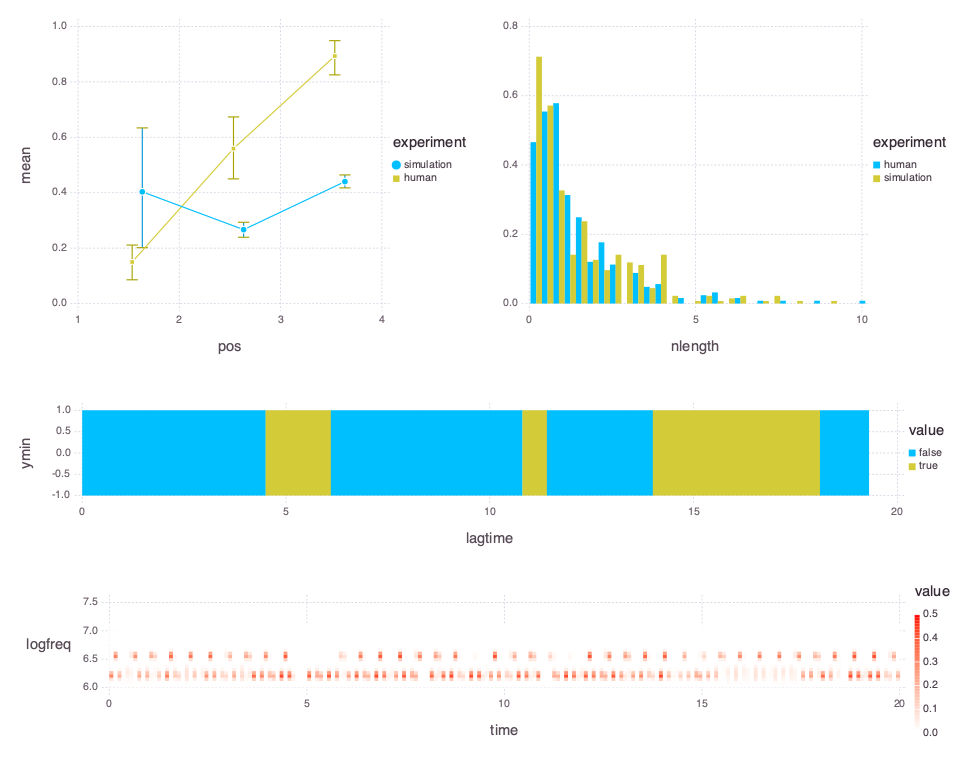

┌ Info: Stimulus is 47.999875 seconds long.
└ @ AuditoryBistabilityLE /Users/davidlittle/googledrive/juliadev/AuditoryBistabilityLE/src/stim.jl:43


false

In [197]:
draw(PNG(10inch,8inch),plot_fitmask(df,params,settings,t_c_a=10000,t_c_m=5))

# Count

In [ ]:
df_stim_rate = @linq df_summary |>
  where(:Δf .== 6) |>
  select(:f_c_σ,:f_c_a,:f_c_m,:s_c_σ,:s_c_a,:s_c_m,:t_c_σ,:t_c_a,:t_c_m,:stim_rate) |>
  rename_levels_for(:stim_rate);

In [ ]:
df_stim_rate |>
  @vlplot(:rect, width=300, height=300,
          title={text="Stimulus Rate",fontSize=18},
          column={field=:level, typ="nominal", sort=["Peripheral", "Cortical", "Object"]},
          x={field=:c_a, typ="ordinal", sort = "ascending",
             axis={title="Magnitude of Adaptation"}},
          y={field=:c_m, typ="ordinal", sort = "descending",
             axis={title="Magnitude of Inhitibtion"}},
          color={field=:stim_rate, aggregate="mean", typ="quantitative", 
                 legend={title="Stimuli / Second"}},
          config={range={heatmap={scheme="viridis"}}})

# Thoughts

This is interesting; the variance in the human data is greater (might suggest multiple sources, consistnet with earlier reports).

That said, it is really distracting from the point I'm trying to caputre at this stage of the analysis. I can image this plot going somewhere else... OR
normalizing by the variance in some way, so that we can determine the extent to which we can match that... for the moment that seems like a reasonable standard.

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

In [ ]:
using PlotAxes

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s],audiospect_stimulus(params[selection,:],settings)[10s .. 30s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 18) .< 1) .& (abs.(:f_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:f_c_m .- 100) .< 1) .& (abs.(:f_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=1.0}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[10s .. 30s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 56) .< 1) .& (abs.(:s_c_a .- 11) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()", column=:percepts,
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
selection = @where(params,(abs.(:s_c_m .- 32) .< 1) .& (abs.(:s_c_a .- 5) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:nlength, bin={step=0.1}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s])

In [ ]:
rplot(bandwidth_ratio(AuditoryBistabilityLE.decompress(masks[1])[25s .. 35s],audiospect_stimulus(params[selection,:],settings)[25s .. 35s,0.4kHz .. 1.2kHz],settings)[1])

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20))

In [ ]:
@where(df,(:pindex .== selection) .& (:length .< 20)) |>
   @vlplot(:bar, width=300, height=300, x={:length, bin={step=0.5}}, y="count()",
           color={field=:percepts, typ="nominal"})

In [ ]:
masks = []
for_results_in(joinpath(datadir,"data")) do entry
    if entry["pindex"] == selection
        push!(masks,entry["mask"])
    end
end

rplot(AuditoryBistabilityLE.decompress(masks[1]))

In [ ]:
@where(df,:pindex .== selection)

In [ ]:
selection = @where(params,(abs.(:t_c_m .- 18) .< 1) .& (abs.(:t_c_a .- 56) .< 1) .& (:Δf .== 6))[:pindex][1]

In [ ]:
# NEXT STEP: get new bandwidth_ratio parameters working, and test them out

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.primary_source)

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
freqs(result.input[:,400Hz .. 1.2kHz])

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 3
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)

In [ ]:
params_dict = Dict(k => params[selection,k] for k in names(params))
params_dict[:Δf] = 12
result = bistable_model(35,params_dict,joinpath("..","src","settings.toml"),interactive=true);

In [ ]:
result.percepts.counts

In [ ]:
rplot(result.percepts.ratio)

In [ ]:
rplot(result.primary_source)